In [126]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [127]:
nc = xr.open_dataset('/g/data/v45/jn8053/CS2_combined_Southern_Ocean_2011-2016_regridded.nc')

In [128]:
# time period
start_time = '2011-01-01'
end_time = '2016-12-31'

In [129]:
# SSH observation
ssh_obs = nc.MDT

In [130]:
nc


<xarray.Dataset>
Dimensions:   (Y: 121, X: 240, nbnd: 2, date: 72)
Coordinates:
  * Y         (Y) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * X         (X) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * date      (date) int32 201101 201102 201103 201104 ... 201610 201611 201612
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (Y, nbnd) float64 ...
    lon_bnds  (X, nbnd) float64 ...
    gw        (Y) float64 ...
    area      (Y, X) float64 ...
    Area      (Y, X) float32 ...
    DOT       (date, Y, X) float32 ...
    MDT       (Y, X) float32 ...
    SLA       (date, Y, X) float32 ...
Attributes:
    Title:        CS2_combined_Southern_Ocean_2011-2016.nc
    Description:  Monthly merged dynamic ocean topography, sea level anomaly ...
    Projection::  Southern hemisphere SSM/I polar stereographic grid (https:/...
    Reference:    Armitage et al., Dynamic topography and sea level anomalies...
    history:      Tue Sep  8 11:16:36 2020: ncks --map weights.nc CS2_combine...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    map_file:     weights.nc
    input_file:   CS2_combined_Southern_Ocean_2011-2016.nc

In [131]:
session = cc.database.create_session()

In [132]:
# get ACCESS-OM2 SSHs
# 1 deg
ssh1 = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'eta_t', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
# 0.25 deg
ssh025 = cc.querying.getvar('025deg_jra55_iaf_omip2_cycle1', 'eta_t', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
# 0.1 deg
ssh01 = cc.querying.getvar('01deg_jra55v13_iaf', 'eta_t', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22777634391872 and this is thread id 22774598854400.
Exception closing connection <sqlite3.Connection object at 0x14b69d9f9030>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/b

In [133]:
# compute the time mean sshs
ssh01 = ssh01.sel(yt_ocean = slice(-90,-50)).mean('time').load()
ssh025 = ssh025.sel(yt_ocean = slice(-90,-50)).mean('time').load()
ssh1 = ssh1.sel(yt_ocean = slice(-90,-50)).mean('time').load()

In [149]:
# regrid the topography to 0.1，0.25，1
ssh_regrid01 = ssh_obs.interp(Y = ssh01.yt_ocean,X = np.arange(0,360,0.1),method='linear')
ssh_regrid025 = ssh_obs.interp(X = np.arange(0,360,0.25),Y = ssh025.yt_ocean,method='linear')
ssh_regrid1 = ssh_obs.interp(X = np.arange(0,360,1),Y = ssh1.yt_ocean,method='linear')
# select the connection regions
ssh_regrid01_connection = ssh_regrid01.sel(X = slice(30,150)).load()
ssh_regrid025_connection = ssh_regrid025.sel(X = slice(30,150)).load()
ssh_regrid1_connection = ssh_regrid1.sel(X = slice(30,150)).load()

In [135]:
# set a new order of xt_ocean
Xt_ocean01 = np.arange(30,150,0.1)
Xt_ocean025 = np.arange(30,150,0.25)
Xt_ocean1 = np.arange(30,150,1)

In [136]:
# change the coordinate of xt_ocean
#01deg
ssh01_connection1 = ssh01.sel(xt_ocean = slice(-280,-210))
ssh01_connection2 = ssh01.sel(xt_ocean = slice(30,80))
ssh01_connection = xr.concat([ssh01_connection2,ssh01_connection1],dim='xt_ocean')
ssh01_connection = xr.DataArray(ssh01_connection, dims = ['yt_ocean','X'], coords = [ssh01.yt_ocean, Xt_ocean01])*100.

In [137]:
# 025deg
ssh025_connection1 = ssh025.sel(xt_ocean = slice(-280,-210))
ssh025_connection2 = ssh025.sel(xt_ocean = slice(30,80))
ssh025_connection = xr.concat([ssh025_connection2,ssh025_connection1],dim='xt_ocean')
ssh025_connection = xr.DataArray(ssh025_connection, dims = ['yt_ocean','X'], coords = [ssh025.yt_ocean, Xt_ocean025])*100.
#1deg
ssh1_connection1 = ssh1.sel(xt_ocean = slice(-280,-210))
ssh1_connection2 = ssh1.sel(xt_ocean = slice(30,80))
ssh1_connection = xr.concat([ssh1_connection2,ssh1_connection1],dim='xt_ocean')
ssh1_connection = xr.DataArray(ssh1_connection, dims = ['yt_ocean','X'], coords = [ssh1.yt_ocean, Xt_ocean1])*100.

In [176]:
# compute anomalies
ano01 = (ssh01_connection.values - ssh_regrid01_connection[:,:1200].values)
ano01 = xr.DataArray(ano01, dims = ['yt_ocean','X'], coords = [ssh01.yt_ocean, Xt_ocean01])

In [177]:
ano025 = (ssh025_connection - ssh_regrid025_connection[:,:480]).load()
ano1 = (ssh1_connection - ssh_regrid1_connection[:,:120]).load()

Text(0.5, 0, 'SSH (cm)')

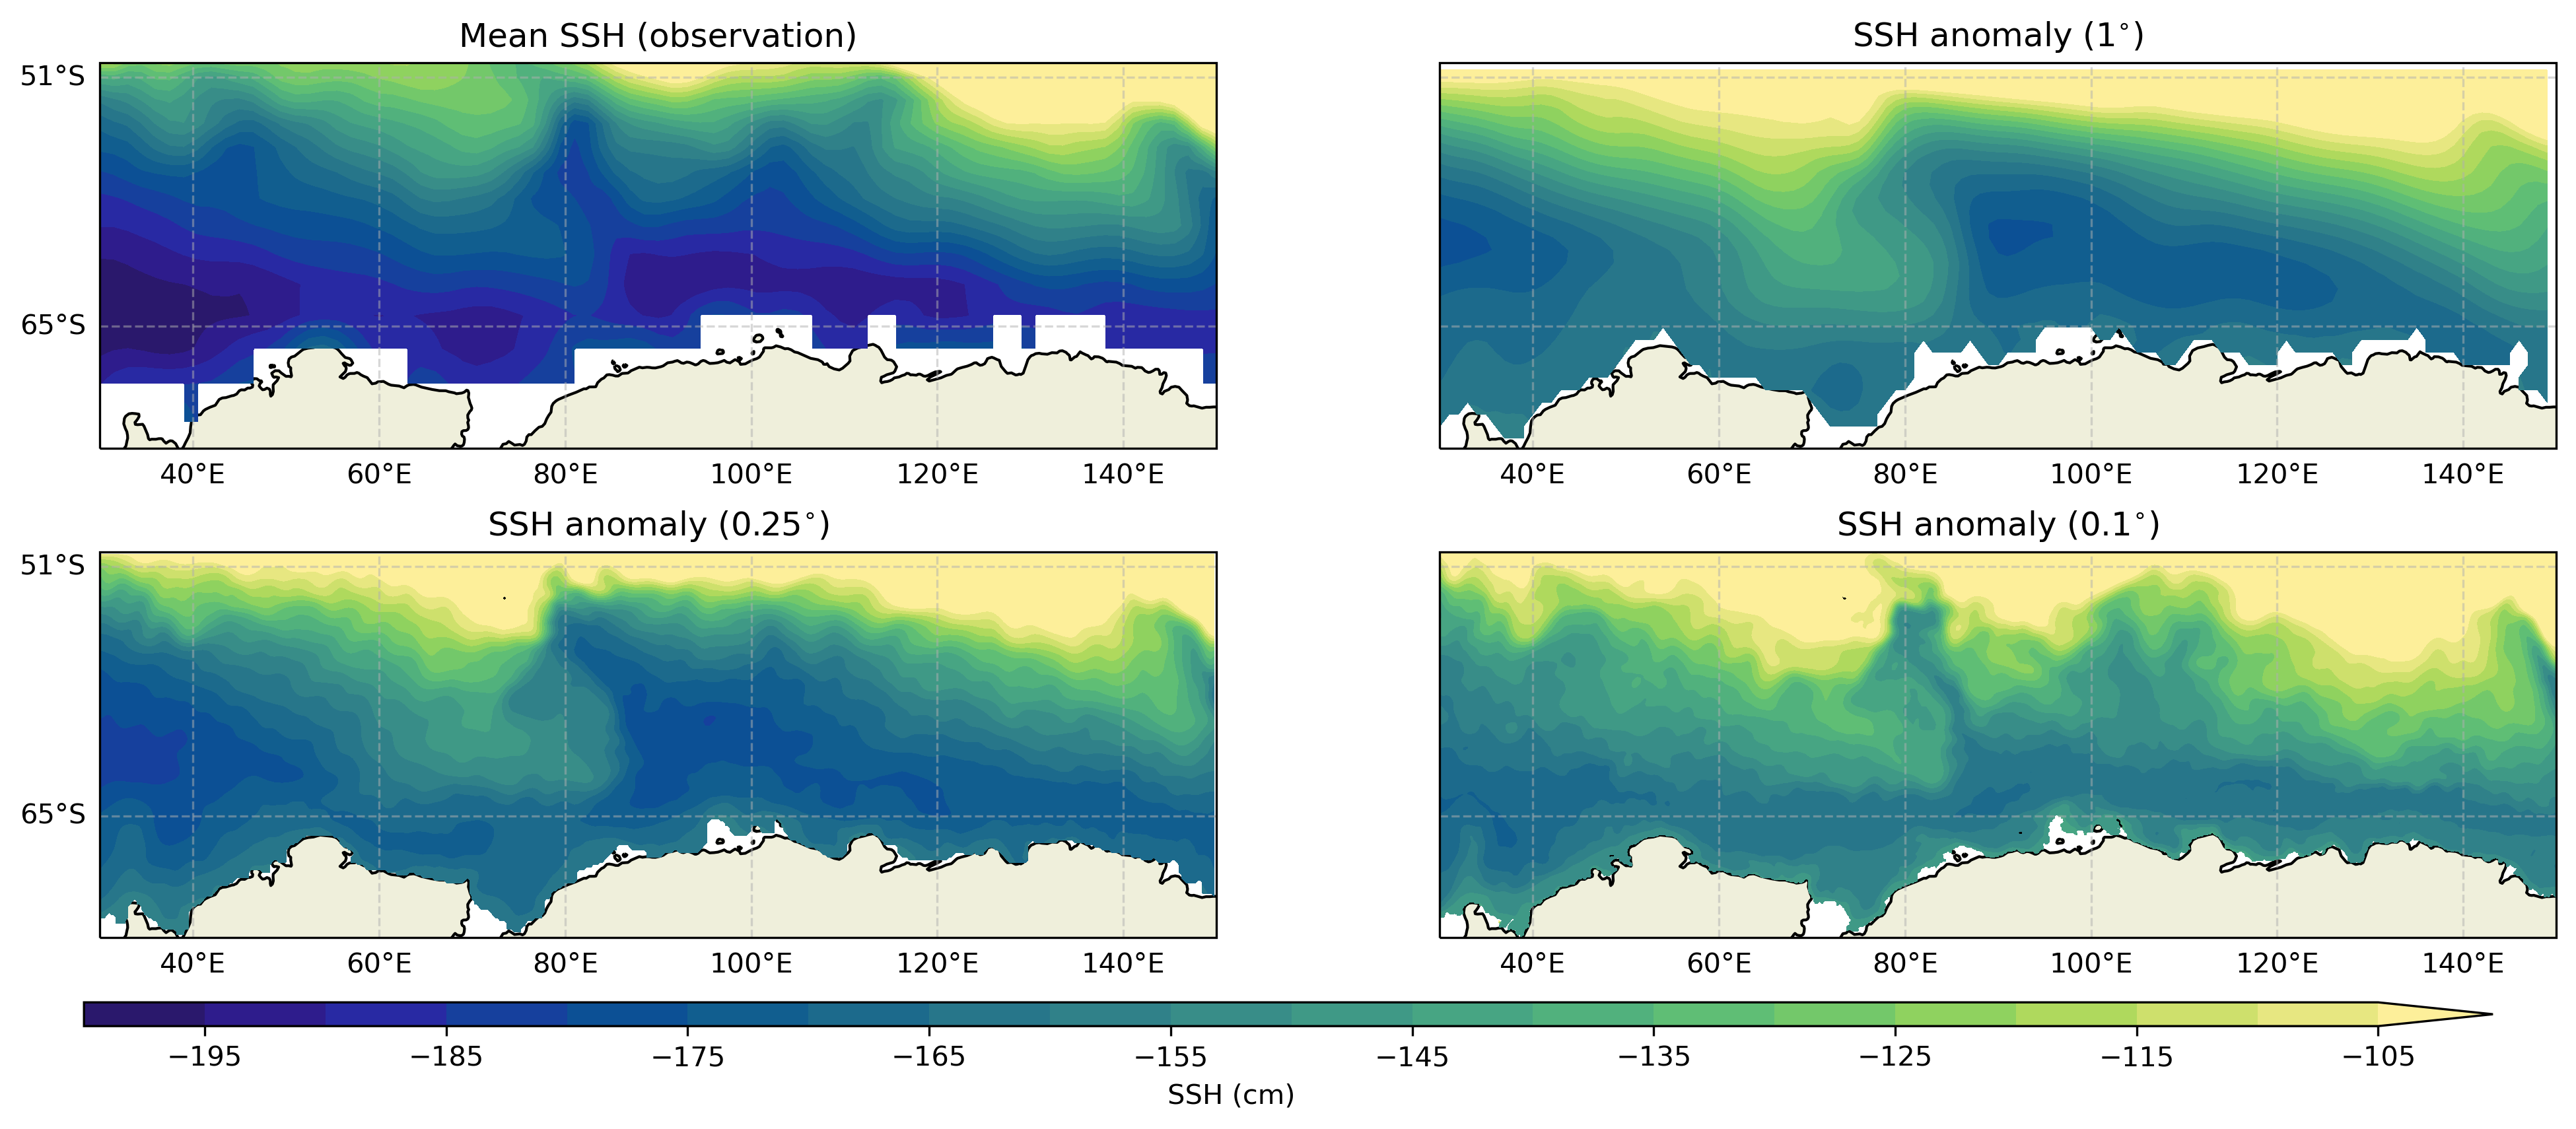

In [186]:
# observation 1 deg regrid
projection=ccrs.Mercator(min_latitude=-70.0, max_latitude=-50.0)
fig = plt.figure(figsize=(16, 6), dpi=300)
ax = plt.subplot(2, 2, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p1 = ssh_regrid_connection.plot.contourf(ax =ax, levels = np.arange(-200,-100,5), transform=ccrs.PlateCarree(),cmap=cm.cm.haline,add_colorbar=False)
ax.set_title('Mean SSH (observation)')
ax. grid(False)
# 1
ax = plt.subplot(2, 2, 2, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylabels_left = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p1 = ssh1_connection.plot.contourf(ax =ax, levels = np.arange(-200,-100,5), transform=ccrs.PlateCarree(),cmap=cm.cm.haline,add_colorbar=False)
ax.set_title('SSH anomaly (1$^{\circ}$)')
ax. grid(False)

# 025
ax = plt.subplot(2, 2, 3, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p2 = ssh025_connection.plot.contourf(ax =ax, levels = np.arange(-200,-100,5), transform=ccrs.PlateCarree(),cmap=cm.cm.haline,add_colorbar=False)
ax.set_title('SSH anomaly (0.25$^{\circ}$)')
ax. grid(False)

# 01
ax = plt.subplot(2, 2, 4, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_left = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p1 = ssh01_connection.plot.contourf(ax =ax, levels = np.arange(-200,-100,5), transform=ccrs.PlateCarree(),cmap=cm.cm.haline,add_colorbar=False)
ax.set_title('SSH anomaly (0.1$^{\circ}$)')
ax. grid(False)

# colorbar 
ax = plt.axes([0.12, 0.06, 0.76, 0.02])
cb = plt.colorbar(p1, cax=ax, orientation='horizontal',extend = 'both')
cb.ax.set_xlabel('SSH (cm)')


Text(0.5, 0, 'SSH anomaly (cm)')

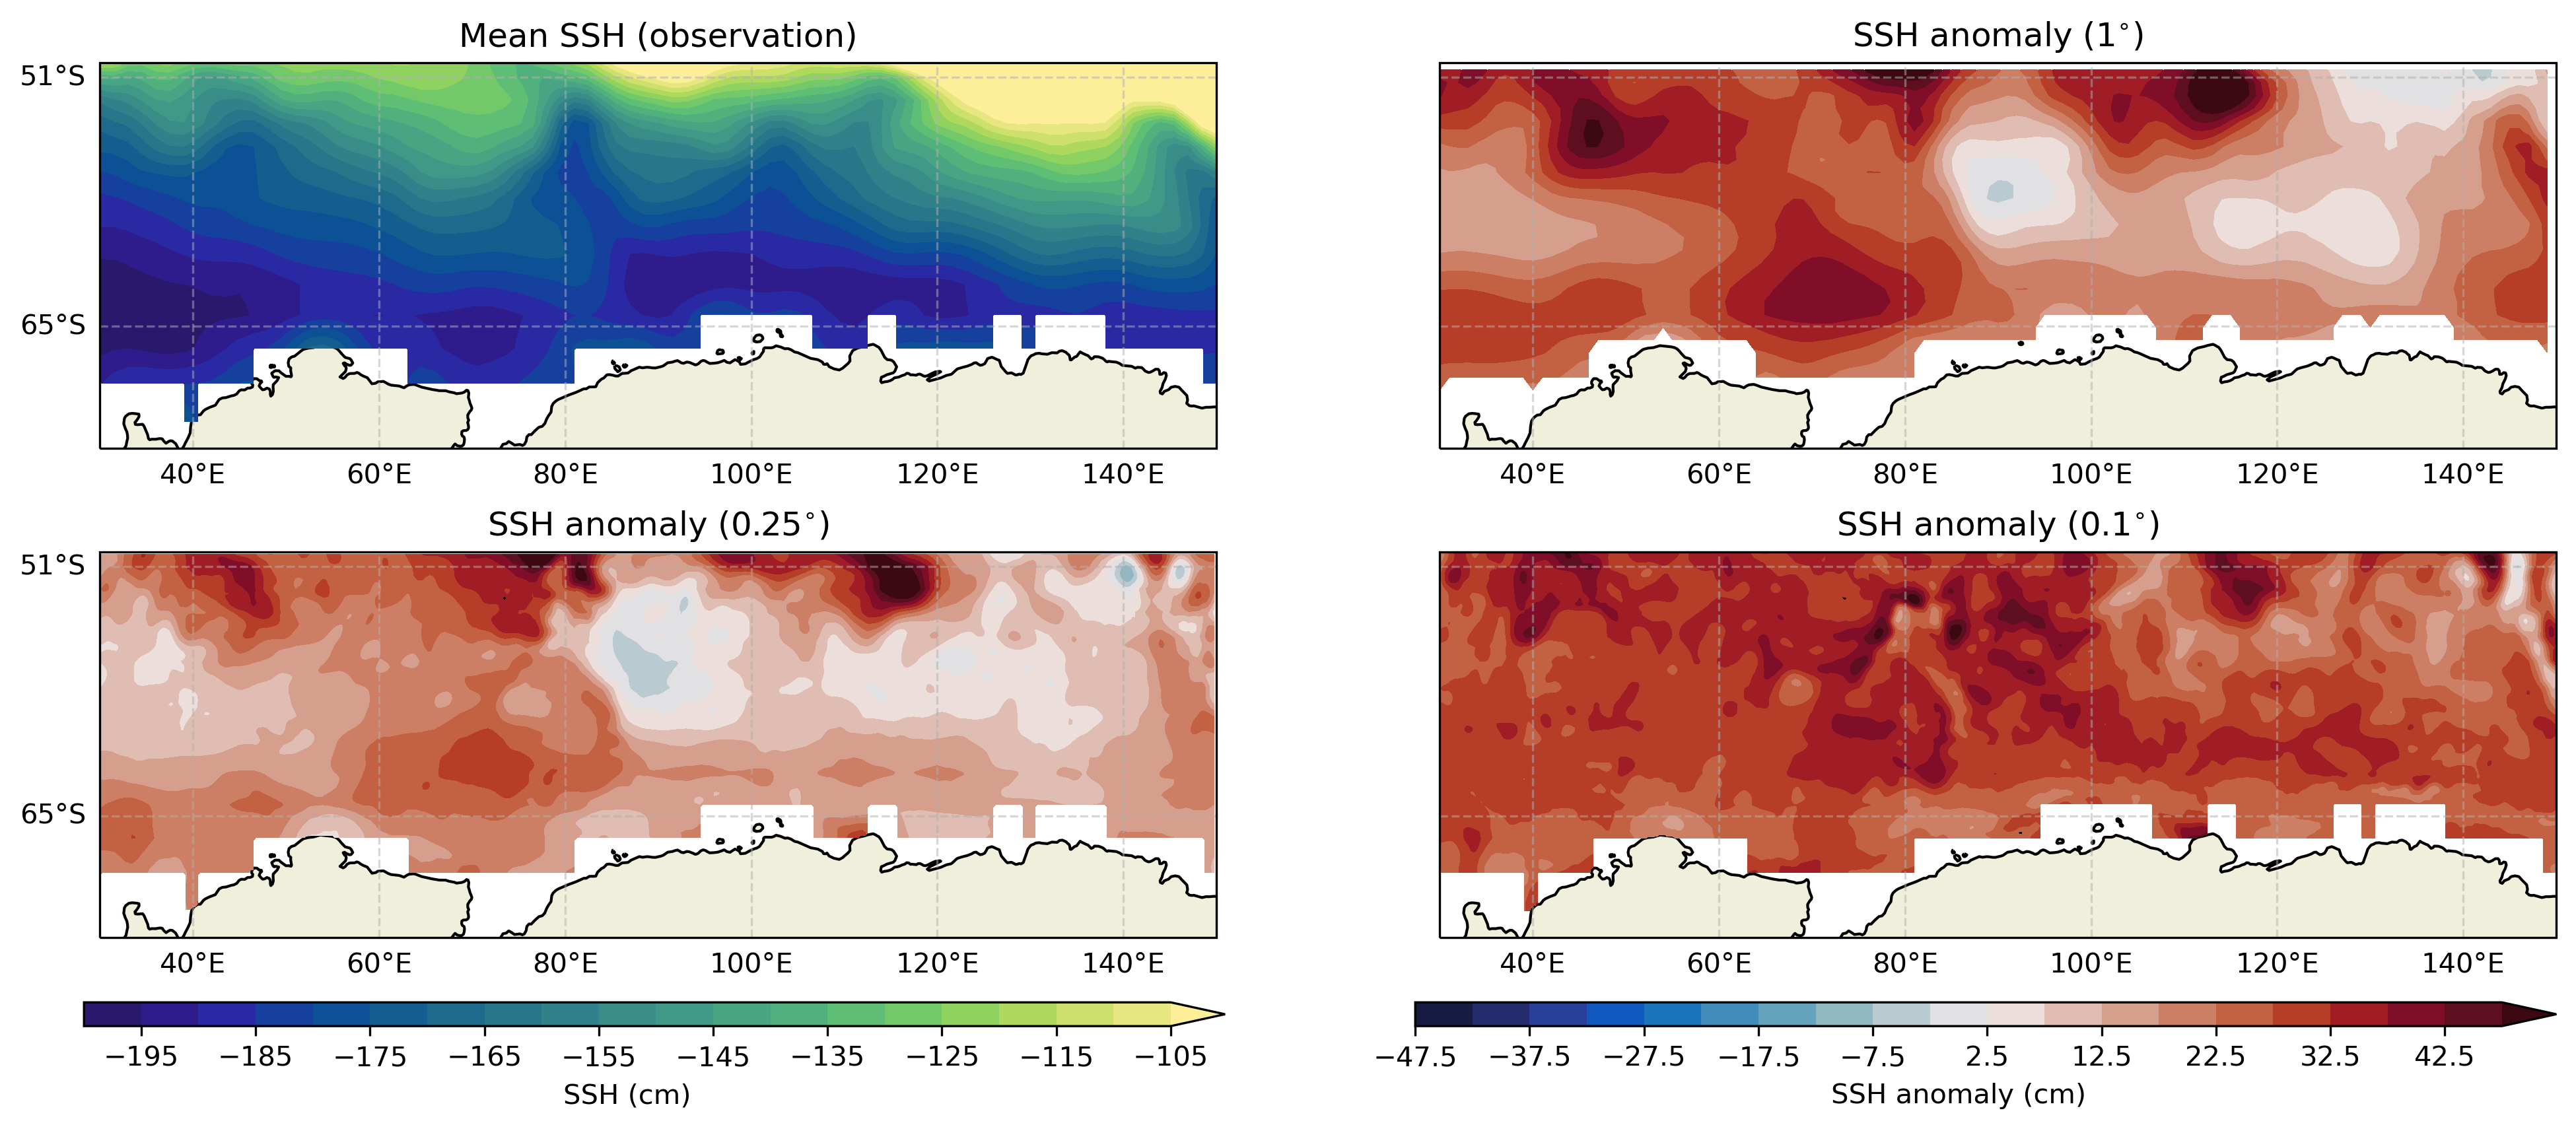

In [190]:
# observation 1 deg regrid
projection=ccrs.Mercator(min_latitude=-70.0, max_latitude=-50.0)
fig = plt.figure(figsize=(16, 6), dpi=300)
ax = plt.subplot(2, 2, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p1 = ssh_regrid_connection.plot.contourf(ax =ax, levels = np.arange(-200,-100,5), transform=ccrs.PlateCarree(),cmap=cm.cm.haline,add_colorbar=False)
ax.set_title('Mean SSH (observation)')
ax. grid(False)
# ano1
ax = plt.subplot(2, 2, 2, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylabels_left = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p2 = ano1.plot.contourf(ax =ax, levels = np.arange(-47.5,50,5),transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('SSH anomaly (1$^{\circ}$)')
ax. grid(False)

# ano025
ax = plt.subplot(2, 2, 3, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p2 = ano025.plot.contourf(ax =ax, levels = np.arange(-47.5,50,5),transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('SSH anomaly (0.25$^{\circ}$)')
ax. grid(False)

# ano01
ax = plt.subplot(2, 2, 4, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([30, 150, -75, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_left = False
lb.ylabels_right = False
lb.ylocator = mticker.FixedLocator([-65, -51])
p2 = (ano01).plot.contourf(ax =ax, levels = np.arange(-47.5,50,5),transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('SSH anomaly (0.1$^{\circ}$)')
ax. grid(False)

# colorbar 
ax = plt.axes([0.12, 0.06, 0.36, 0.02])
cb = plt.colorbar(p1, cax=ax, orientation='horizontal',extend = 'both')
cb.ax.set_xlabel('SSH (cm)')

ax = plt.axes([0.54, 0.06, 0.36, 0.02])
cb = plt.colorbar(p2, cax=ax, orientation='horizontal',extend = 'both')
cb.ax.set_xlabel('SSH anomaly (cm)')

In [193]:
x = ano01.max()
y = ano01.min()

In [195]:
[x,y]

[<xarray.DataArray ()>
 array(51.30519261),
 <xarray.DataArray ()>
 array(-3.08068716)]

In [196]:
x = ano025.max()
y = ano025.min()

In [197]:
[x,y]

[<xarray.DataArray ()>
 array(67.62421468),
 <xarray.DataArray ()>
 array(-12.33533303)]

In [198]:
x = ano1.max()
y = ano1.min()

In [199]:
[x,y]

[<xarray.DataArray ()>
 array(59.82881207),
 <xarray.DataArray ()>
 array(-4.10140307)]